In [1]:
%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

# Bibliotecas complementares
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA

import numpy as np
from scipy.stats import truncnorm

#Settings
Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

#dt_halos['redshift_true','m200c', 'richness']

def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    
    lnr_cut = np.array(
        [rich_model.get_cut(lnM[i], z[i]) for i in range(len(dt_halos))])

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    lnR_ext = lnR[sigma_cut_array]
    lnr_cut = lnr_cut[sigma_cut_array] 
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnr_cut, lnR_ext 




In [3]:
# Mass bins 

M_bins = ((0.0, 31.0), (31.0, 32.0), (32.0, 33.0), (33.0, 34.0), (34.0, 36.0))

In [4]:
fit_results_ascaso = []
fit_results_ext = []

for m,n in M_bins:
    
    dt_halos = Table(DC2_halos_m200c[1].data)
    catalog_cut = np.logical_and ( np.log(dt_halos['m200c']) > m, np.log(dt_halos['m200c']) < n )
    dt_halos = dt_halos[catalog_cut]
    
    rmdata = create_richness_mass_calib(dt_halos)
    
    use_ascaso = False

    ascaso = Nc.ClusterMassAscaso()
    ascaso.param_set_by_name("mup0", 4.45393539397061)
    ascaso.param_set_by_name("mup1", 0.538092645909241)
    ascaso.param_set_by_name("mup2", 0.931306629373459)
    ascaso.param_set_by_name("sigmap0", 0.674689968522022)
    ascaso.param_set_by_name("sigmap1", 0.0645030252979038)
    ascaso.param_set_by_name("sigmap2", -0.244363116863723)
    ascaso.param_set_by_name("cut", 6.0)

    lnrich_ext = Nc.ClusterMassLnrichExt()
    lnrich_ext.param_set_by_name("mu", 4.6242757216997)
    lnrich_ext.param_set_by_name("muM1", 0.889048886264161)
    lnrich_ext.param_set_by_name("muZ1", 1.79497076479917)
    lnrich_ext.param_set_by_name("muM2", 0.0450951709800376)
    lnrich_ext.param_set_by_name("muZ2", -0.138595811451779)
    lnrich_ext.param_set_by_name("muMZ", 0.149069152028862)

    lnrich_ext.param_set_by_name("sigma0", 0.292617629679933)
    lnrich_ext.param_set_by_name("sigmaM1", 0.020214679082921)
    lnrich_ext.param_set_by_name("sigmaZ1", -0.0138978042917192)
    lnrich_ext.param_set_by_name("sigmaM2", 0.0158281051864331)
    lnrich_ext.param_set_by_name("sigmaZ2", 0.00863493615093572)
    lnrich_ext.param_set_by_name("sigmaMZ", 0.0384952480360606)

    lnrich_ext.param_set_by_name("cut", 5.40359407583253)
    lnrich_ext.param_set_by_name("cutM1", -0.0113493800219799)
    lnrich_ext.param_set_by_name("cutZ1", -0.657684152142328)

    mset_ascaso = Ncm.MSet()
    mset_ascaso.set(ascaso)

    mset_ext = Ncm.MSet()
    mset_ext.set(lnrich_ext)
    
    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)

    lh = Ncm.Likelihood.new(dset)

    mset_ascaso.param_set_all_ftype(Ncm.ParamType.FREE)
    mset_ext.param_set_all_ftype(Ncm.ParamType.FREE)

    fit_ascaso = Ncm.Fit.new(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL)

    fit_ext = Ncm.Fit.new(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL)

    fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    
    lnM = np.log(dt_halos["m200c"])  # ln(mass)
    z = dt_halos["redshift_true"]  # redshift
    lnR = np.log(dt_halos["richness"])  # ln(richness)
    
    res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso  = compute_res(ascaso)

    res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext  = compute_res(lnrich_ext)
    
    fit_results_ascaso.append((res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso))
    fit_results_ext.append((res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext))


#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#....................................................................................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:21.1944150
#  iteration            [000911]
#  function evaluations [000913]
#  gradient evaluations [000000]
#  degrees of freedom   [374765]
#  m2lnL     =     119954.969235722 (     119954.97 )
#  Fit parameters:
#     4.36808211983364     0.658325267016186    1.20326982399858     0.163331817118984   -0.0710084579336011  -0.131367555099055    5.82354721266413    
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 447335.40645955       
#  - relative improvement: 0.

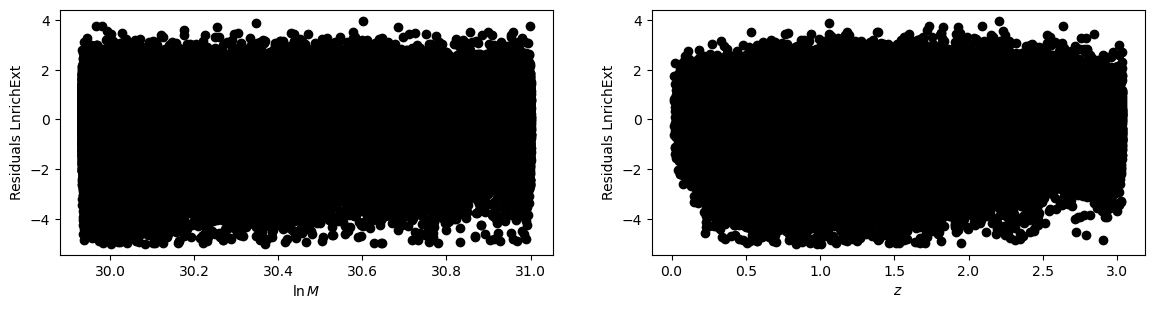

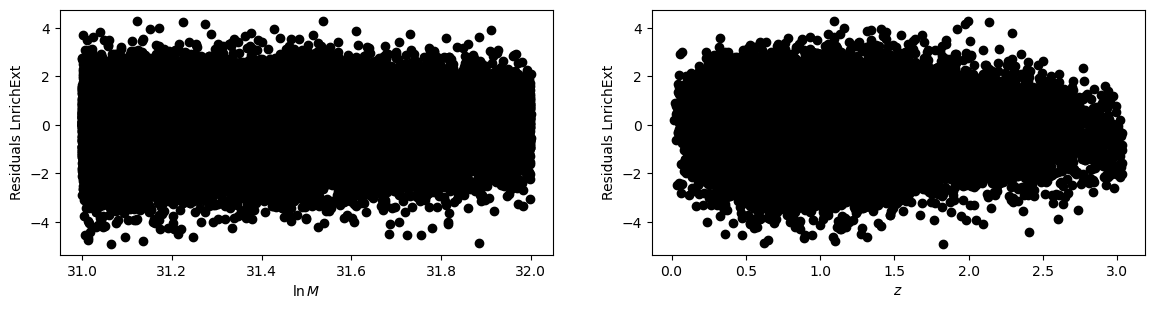

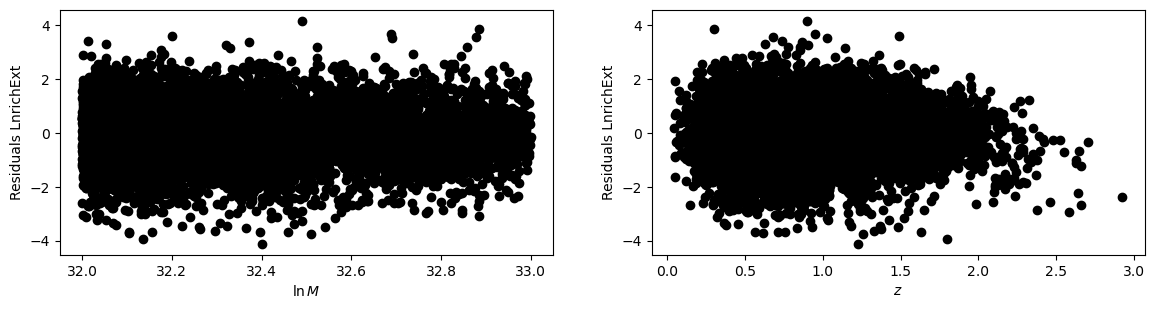

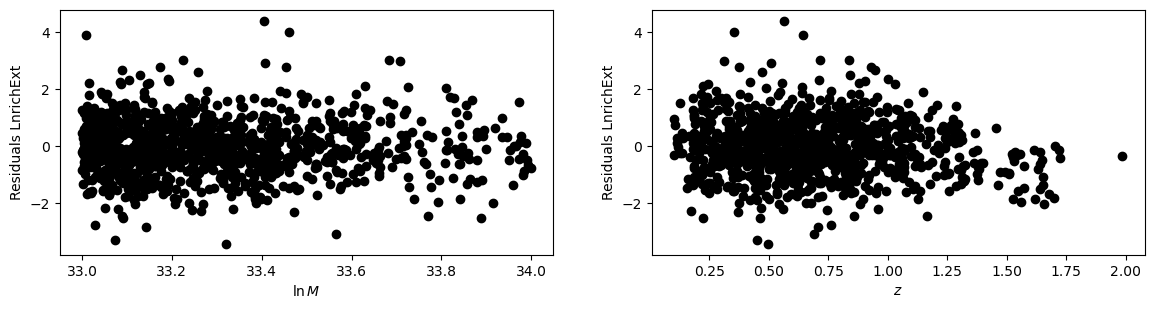

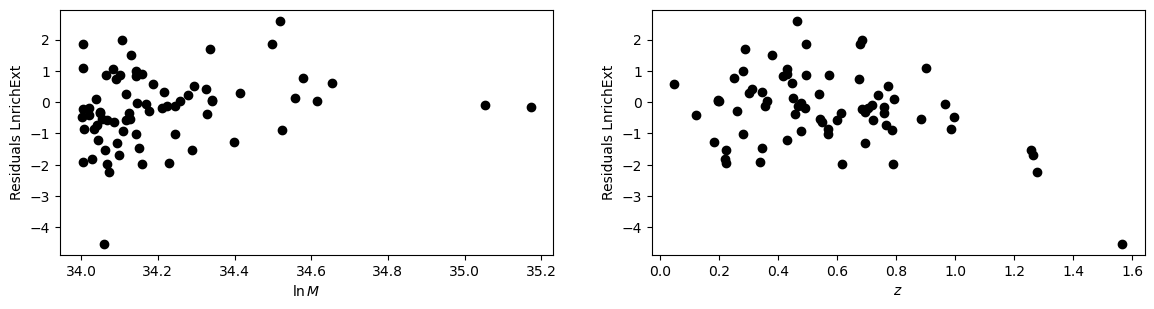

In [5]:
# Residuals

for i, j, k, l, m, n in fit_results_ext:
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)

    ax1.scatter(l, i, c="k")
    ax1.set_xlabel("$\ln M$")
    ax1.set_ylabel("Residuals LnrichExt")

    ax2.scatter(k, i, c="k")
    ax2.set_xlabel("$z$")
    ax2.set_ylabel("Residuals LnrichExt")



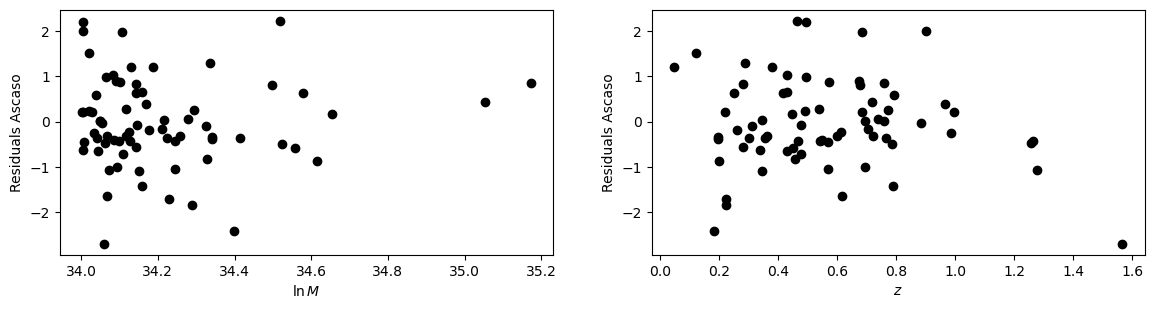

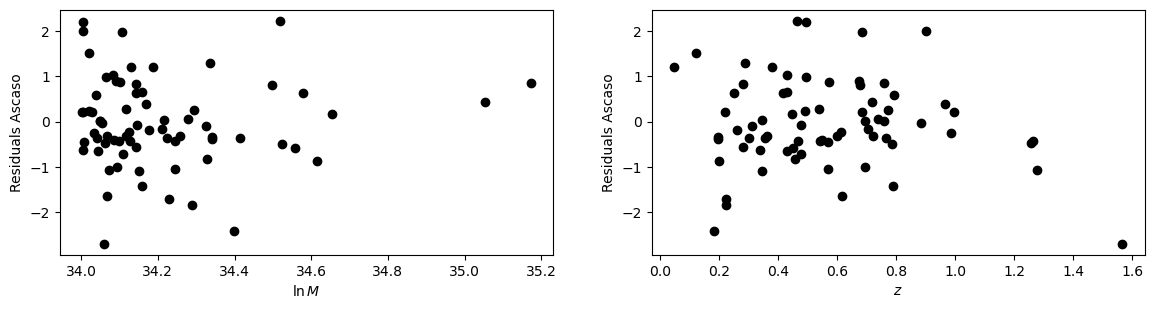

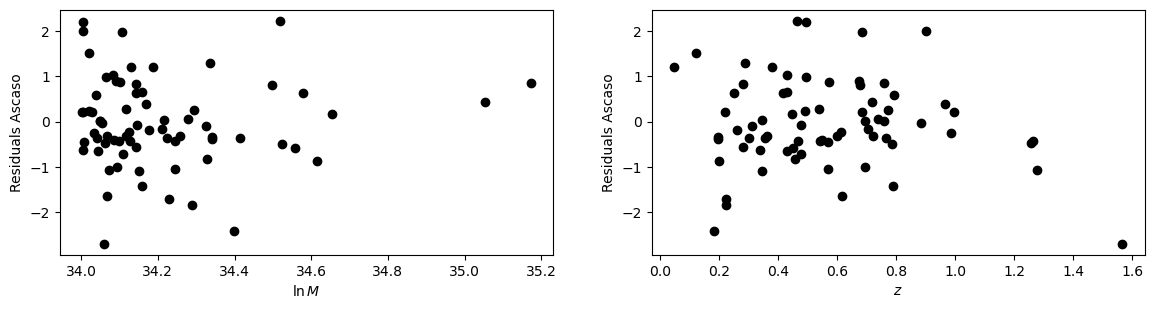

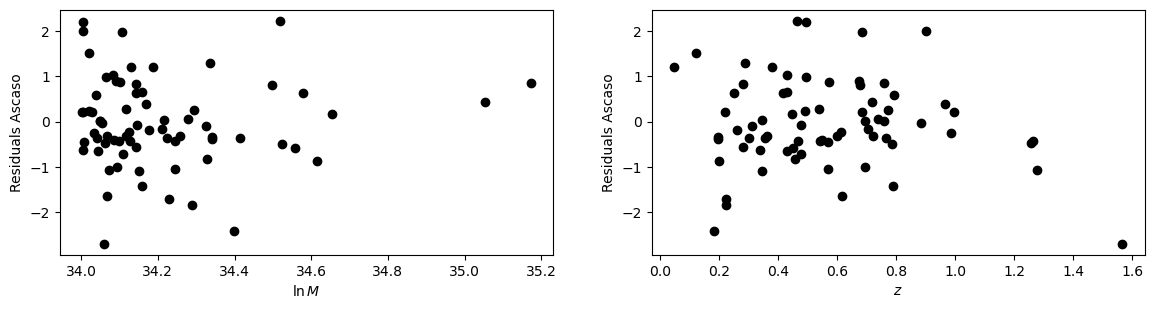

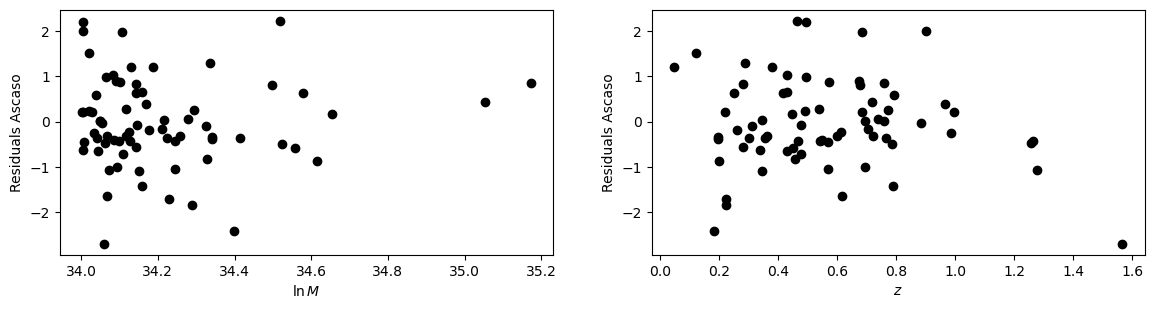

In [6]:
for i, j, k, l, m, n in fit_results_ascaso:
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)

    ax1.scatter(lnM_sigma_cut_ascaso, res_ascaso, c="k")
    ax1.set_xlabel("$\ln M$")
    ax1.set_ylabel("Residuals Ascaso")

    ax2.scatter(z_sigma_cut_ascaso, res_ascaso, c="k")
    ax2.set_xlabel("$z$")
    ax2.set_ylabel("Residuals Ascaso")


Text(0.5, 1.0, 'Residuals distribuition Ascaso')

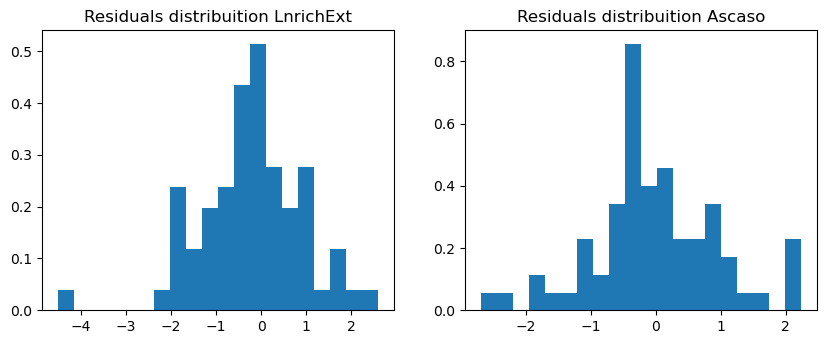

In [7]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.hist(res_ext, bins=20, density=True)
ax1.set_title("Residuals distribuition LnrichExt")

ax2.hist(res_ascaso, bins=20, density=True)
ax2.set_title("Residuals distribuition Ascaso")